# DTI Analysis using DIPY

Author: Keshvi Gupta

## Import necessary packages

In [1]:
# Data manipulation and visualization
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Neuroimaging tools
import nibabel as nib
from nilearn.plotting import plot_anat

# Diffusion imaging and analysis
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki
import dipy.core.gradients as dpg

# Image processing and analysis
from dipy.denoise.localpca import mppca
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import fractional_anisotropy, mean_diffusivity
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere, get_sphere
from dipy.direction import peaks_from_model
from dipy.viz import window, actor, has_fury

# Image filtering and visualization
from scipy.ndimage.filters import gaussian_filter
from prettytable import PrettyTable
from mpl_toolkits.mplot3d import Axes3D

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Display plots in the notebook
%matplotlib inline

/var/folders/9w/16vdgrh16h70kmd45bktc2f00000gn/T/ipykernel_43083/587050673.py:29: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


## Data overview

In [2]:
# Load a neuroimaging data file (MRI scan) using the Nibabel library
img_fraw = nib.load("../dti_data/AA_R079_L/AA_R079_L_8_ep2d_diff_30_iso.nii.gz")

# Print the dimensions (shape) of the loaded MRI data
print(img_fraw.shape)

# Print the header information associated with the MRI data
print(img_fraw.header)

(112, 112, 60, 65)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 57
dim             : [  4 112 112  60  65   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         1.9642857  1.9642857  2.5        9.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : alternating increasing 2
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=99;Time=111337.350;phase=1'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.99797153
quatern_d   

## Visualization of Diffusion Metrics

In [3]:
# Directory containing DREEM EEG H5 files
data_dir = '../dti_data'

# Directory where images will be saved
img_dir = 'dti_outputs'

In [4]:
# Setup directories
for curr_dir in [data_dir, img_dir]:
    try:
        os.makedirs(curr_dir)
    except OSError as error:
        print(error)

[Errno 17] File exists: '../dti_data'
[Errno 17] File exists: 'dti_outputs'


In [5]:
# List all files in data directory
f_list = os.walk(data_dir)
f_list = [curr_f for curr_f in f_list]
f_list = f_list[1:]

In [6]:
# Create a dictionary to store file names for each directory
directory_files = {}

# Iterate through a list of file names and directories (f_list)
for f_curr in f_list:
    fraw_dir = f_curr[0]
    fraw_list = f_curr[2]

    # Skip directories with no files
    if not fraw_list:
        continue

    # Check if the directory is already in the dictionary; if not, create an entry
    if fraw_dir not in directory_files:
        directory_files[fraw_dir] = []

    # Skip directories without files again
    if not fraw_list:
        continue

    # Assuming each directory contains one file with each of these extensions: .gz, .bval, .bvec
    fraw_file = next((f for f in fraw_list if f.endswith('.gz')), None)
    fbval_file = next((f for f in fraw_list if f.endswith('.bval')), None)
    fbvec_file = next((f for f in fraw_list if f.endswith('.bvec')), None)

    # If all three required files are found, store them in the directory's entry
    if fraw_file and fbval_file and fbvec_file:
        directory_files[fraw_dir] = (fraw_file, fbval_file, fbvec_file)

# Create a table to display directory and file information
path_tbl = PrettyTable()
path_tbl.field_names = ['#', 'Directory', 'File name']
directory_count = 0

# Populate the table with directory and file names
for directory, files in directory_files.items():
    directory_count += 1
    file_names = '\n'.join(files)
    path_tbl.add_row([directory_count, directory, file_names])
    path_tbl.add_row(['-' * 5, '-' * 40, '-' * 60])  # Adding dashed lines to separate directories

# Remove the last dashed line, if present
if len(path_tbl._rows) > 0 and path_tbl._rows[-1][0] == '-' * 5:
    path_tbl.del_row(-1)

# Print the table displaying directory and file information
print(path_tbl)

+-------+------------------------------------------+--------------------------------------------------------------+
|   #   |                Directory                 |                          File name                           |
+-------+------------------------------------------+--------------------------------------------------------------+
|   1   |            ../dti_data/COV102            |               Cov102_8_ep2d_diff_30_iso.nii.gz               |
|       |                                          |                Cov102_8_ep2d_diff_30_iso.bval                |
|       |                                          |                Cov102_8_ep2d_diff_30_iso.bvec                |
| ----- | ---------------------------------------- | ------------------------------------------------------------ |
|   2   |            ../dti_data/COV132            |               Cov132_8_ep2d_diff_30_iso.nii.gz               |
|       |                                          |                Cov1

In [7]:
# Function to save b-values and b-vectors
def save_bvals_bvecs(b_values, b_vectors, output_dir, subject_id):
    # Create a DataFrame for b-values
    bval_df = pd.DataFrame({'B-values': b_values})
    
    # Create a DataFrame for b-vectors
    bvec_df = pd.DataFrame(b_vectors, columns=['B-vector (X)', 'B-vector (Y)', 'B-vector (Z)'])

    # Merge b-values and b-vectors DataFrames
    merged_df = pd.concat([bval_df, bvec_df], axis=1)

    # Replace with your desired Excel file path
    excel_output = os.path.join(output_dir, f"{subject_id}_original_bvals_bvecs.xlsx")

    # Save the merged DataFrame to an Excel file
    merged_df.to_excel(excel_output, index=False, engine='openpyxl')

    print(f"Original Bvals & Bvecs saved for subject: {subject_id}")

In [8]:
# Function to generate diffusion metric plots
def generate_diffusion_metric_plots(dti_fa, dti_md, dti_ad, dti_rd, bvals, bvecs, output_dir, subject_id, axial_slice=30):
    
    # Create a 2x2 grid of subplots for FA, MD, AD, and RD
    fig1, ax = plt.subplots(1, 4, figsize=(12, 6),
                            subplot_kw={'xticks': [], 'yticks': []})

    # Adjust subplot spacing
    fig1.subplots_adjust(hspace=0.3, wspace=0.05)

    # Display FA, MD, AD, and RD on subplots
    ax.flat[0].imshow(dti_fa[:, :, axial_slice].T, cmap='gray',
                      vmin=0, vmax=0.7, origin='lower')
    ax.flat[0].set_title(f'FA - Subject: {subject_id}')
    ax.flat[1].imshow(dti_md[:, :, axial_slice].T, cmap='gray',
                      vmin=0, vmax=2.0e-3, origin='lower')
    ax.flat[1].set_title(f'MD - Subject: {subject_id}')
    ax.flat[2].imshow(dti_ad[:, :, axial_slice].T, cmap='gray',
                      vmin=0, vmax=2.0e-3, origin='lower')
    ax.flat[2].set_title(f'AD - Subject: {subject_id}')
    ax.flat[3].imshow(dti_rd[:, :, axial_slice].T, cmap='gray',
                      vmin=0, vmax=2.0e-3, origin='lower')
    ax.flat[3].set_title(f'RD - Subject: {subject_id}')

    # Save the plot as an image file (e.g., PNG) with higher DPI
    plt.savefig(os.path.join(output_dir, f"{subject_id}_diffusion_metrics.png"), dpi=300)
    plt.show()

In [9]:
def save_tensor_ellipsoids(dti_fit, colored_fa, output_dir, subject_id, axial_slice=30):
    # Create a new 3D scene for tensor ellipsoids visualization
    scene = window.Scene()

    # Get the repulsion724 sphere
    sphere = get_sphere('repulsion724')

    # Extract relevant slices of eigenvalues and eigenvectors for the specified slice
    evals = dti_fit.evals[:, :, axial_slice:axial_slice + 1]
    evecs = dti_fit.evecs[:, :, axial_slice:axial_slice + 1]

    # Normalize colored FA for visualization
    cfa = colored_fa[:, :, axial_slice:axial_slice + 1]
    cfa /= cfa.max()
    
    # Add tensor ellipsoids to the scene
    scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,
                                  scale=0.7))

    # Define the output file path for tensor ellipsoids PNG
    tensor_ellipsoids_file = os.path.join(output_dir, f"{subject_id}_tensor_ellipsoids.png")

    # Record the scene as a PNG image
    window.record(scene, n_frames=1, out_path=tensor_ellipsoids_file, size=(600, 600))

    print(f"Tensor Ellipsoids saved for subject: {subject_id}")

In [10]:
# Function to generate colored FA plot
def generate_colored_fa_plot(dti_fa, tenfit, output_dir, subject_id, axial_slice=30):
    # Clip FA values to ensure they are between 0 and 1
    dti_fa = np.clip(dti_fa, 0, 1)
    
    # Generate colored FA
    colored_fa = dti.color_fa(dti_fa, tenfit.evecs)

    # Increase figure size
    plt.figure(figsize=(4, 4))

    # Configure the subplot
    plt.subplot(1, 1, 1).set_axis_off()
    plt.imshow(colored_fa[:, :, axial_slice], cmap='viridis', origin='lower', interpolation='bilinear', extent=[0, colored_fa.shape[1], 0, colored_fa.shape[0]])
    plt.title(f'Color Coded FA - Subject: {subject_id}')

    # Ensure a tight layout
    plt.tight_layout()

    # Increase the DPI for saving the image
    plt.savefig(os.path.join(output_dir, f"{subject_id}_colored_fa.png"), dpi=300)
    plt.show()
    
    # Check if tensor ellipsoids already exist for this subject
    if not os.path.exists(os.path.join(output_dir, f"{subject_id}_tensor_ellipsoids.png")):
        # Calculate tensor ellipsoids and save them as PNG
        save_tensor_ellipsoids(dti_fit, colored_fa, output_dir, subject_id)

In [11]:
def save_csa_direction_field(csa_peaks, output_dir, subject_id):
    # Create a 3D scene for CSA direction field visualization
    scene = window.Scene()
    scene.add(actor.peak_slicer(csa_peaks.peak_dirs,
                                csa_peaks.peak_values,
                                colors=None))

    # Define the output file path for CSA direction field PNG
    csa_direction_field_file = os.path.join(output_dir, f"{subject_id}_csa_direction_field.png")

    # Record the scene as a PNG image
    window.record(scene, out_path=csa_direction_field_file, size=(900, 900))

    print(f"CSA Direction Field saved for subject: {subject_id}")


Output files for 'COV102' already exist. Skipping...

Output files for 'COV132' already exist. Skipping...

Output files for 'COV076' already exist. Skipping...

Output files for 'AA_R359_L' already exist. Skipping...

Output files for 'COV085' already exist. Skipping...

Output files for 'COV048' already exist. Skipping...

Output files for 'AA_394' already exist. Skipping...

Output files for 'AA_R165_L' already exist. Skipping...

Output files for 'COV099' already exist. Skipping...

Processing subject 'COV117' ...


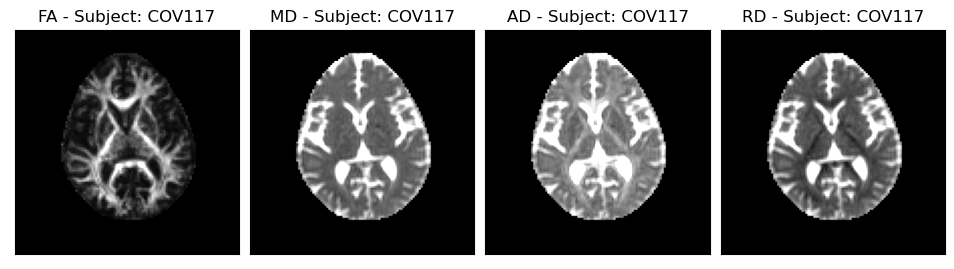

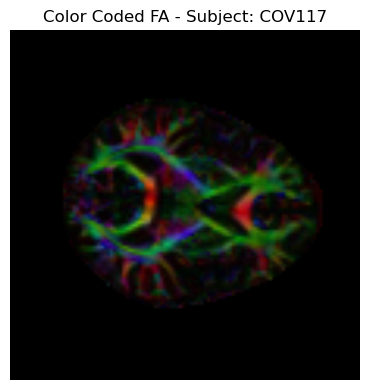

Tensor Ellipsoids saved for subject: COV117
CSA Direction Field saved for subject: COV117

Output files for 'COV128' already exist. Skipping...

Output files for 'COV126' already exist. Skipping...

Output files for 'COV129' already exist. Skipping...

Output files for 'COV044' already exist. Skipping...

Output files for 'COV081' already exist. Skipping...

Processing subject 'AAL_054' ...
Original Bvals & Bvecs saved for subject: AAL_054


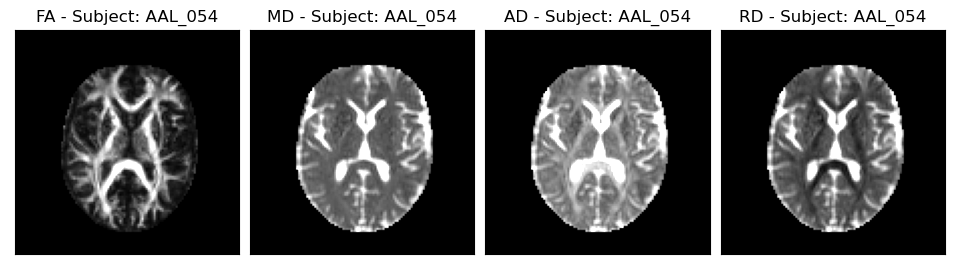

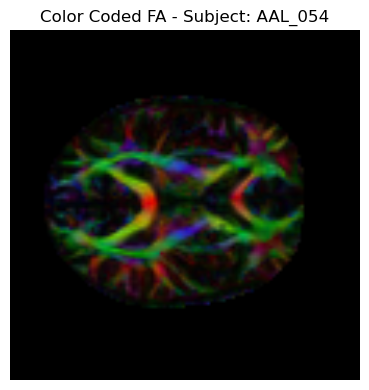

Tensor Ellipsoids saved for subject: AAL_054
CSA Direction Field saved for subject: AAL_054

Output files for 'COV075' already exist. Skipping...

Processing subject 'AAL_052' ...
Original Bvals & Bvecs saved for subject: AAL_052


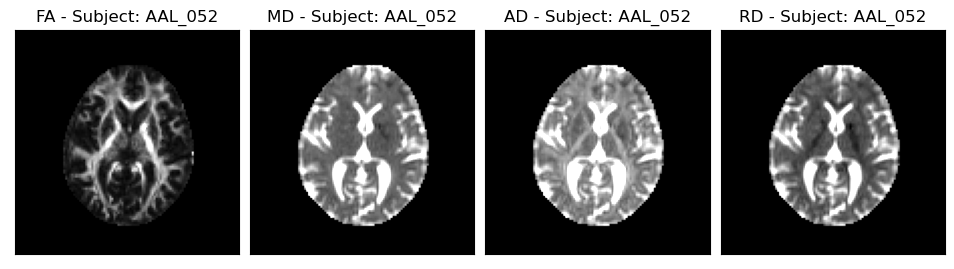

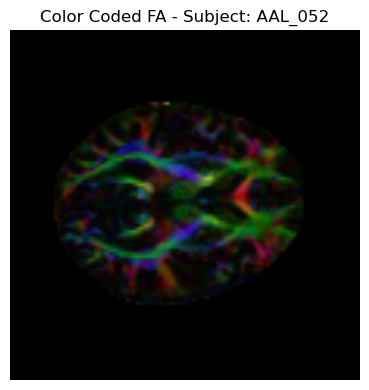

Tensor Ellipsoids saved for subject: AAL_052
CSA Direction Field saved for subject: AAL_052

Output files for 'COV094' already exist. Skipping...

Output files for 'AA_R079_L' already exist. Skipping...

Output files for 'AA_R152_L' already exist. Skipping...

Output files for 'AA_R429_L' already exist. Skipping...


In [12]:
# Continue the processing for each directory of subjects
for directory, files in directory_files.items():
    
    # Extract the subject ID from the directory path
    subject_id = os.path.basename(directory)
    # Define the output directory path for the current subject
    output_dir = f"dti_outputs/{subject_id}"
    
    # Create the subject-specific output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract file names for DTI, b-values, and b-vectors
    fraw, fbval, fbvec = files
    
    # Check if the specific files already exist in the output directory
    bvals_bvecs_file = os.path.join(output_dir, f"{subject_id}_original_bvals_bvecs.xlsx")
    diffusion_metrics_file = os.path.join(output_dir, f"{subject_id}_diffusion_metrics.png")
    colored_fa_file = os.path.join(output_dir, f"{subject_id}_colored_fa.png")
    tensor_ellipsoids_file = os.path.join(output_dir, f"{subject_id}_tensor_ellipsoids.png")
    csa_direction_field_file = os.path.join(output_dir, f"{subject_id}_csa_direction_field.png")
    
    # Store the file paths in a list for future reference
    file_paths_to_check = [
        bvals_bvecs_file,
        diffusion_metrics_file,
        colored_fa_file,
        tensor_ellipsoids_file,
        csa_direction_field_file
    ]

    # Check if any of the files are missing in the output directory
    if any(not os.path.exists(file_path) for file_path in file_paths_to_check):
        print(f"\nProcessing subject '{subject_id}' ...")
    else:
        print(f"\nOutput files for '{subject_id}' already exist. Skipping...")
        continue

    # Load the DTI data
    fraw_img = nib.load(os.path.join(directory, fraw))
    data = fraw_img.get_fdata()
    affine = fraw_img.affine

    # Load the b-values and b-vectors
    bvals, bvecs = read_bvals_bvecs(os.path.join(directory, fbval), os.path.join(directory, fbvec))
    
    # Save b-values and b-vectors if not already saved
    if not os.path.exists(bvals_bvecs_file):
        save_bvals_bvecs(bvals, bvecs, output_dir, subject_id)

    # Processing code for DTI data
    gtab = dpg.gradient_table(bvals, bvecs)
    maskdata, mask = median_otsu(data,
                                 vol_idx=[0, 1],
                                 median_radius=8,
                                 numpass=2,
                                 autocrop=False,
                                 dilate=3)
    
    fwhm = 1.25
    gauss_std = fwhm / np.sqrt(8 * np.log(2))  # converting fwhm to Gaussian std
    data_smooth = np.zeros(data.shape)
    for v in range(data.shape[-1]):
        data_smooth[..., v] = gaussian_filter(data[..., v], sigma=gauss_std)

    dti_model = dti.TensorModel(gtab)
    dti_fit = dti_model.fit(data_smooth, mask=mask)

    # Calculate diffusion metrics
    dti_FA = dti_fit.fa
    dti_MD = dti_fit.md
    dti_AD = dti_fit.ad
    dti_RD = dti_fit.rd
        
    # Check if diffusion metrics already exist for this subject
    if not os.path.exists(diffusion_metrics_file):

        # Generate and save the diffusion metric plots
        generate_diffusion_metric_plots(dti_FA, dti_MD, dti_AD, dti_RD, bvals, bvecs, output_dir, subject_id)

    # Check if colored FA and tensor ellipsoids already exist for this subject
    if not (os.path.exists(tensor_ellipsoids_file) and os.path.exists(colored_fa_file)):
        # Generate and save the colored FA plot
        generate_colored_fa_plot(dti_FA, dti_fit, output_dir, subject_id)
    
    # Check if CSA direction field already exists for this subject
    if not os.path.exists(csa_direction_field_file):
        # Calculate the response and ratio for single-shell spherical deconvolution
        response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)

        # Create a Constrained Spherical Deconvolution (CSD) model
        csa_model = CsaOdfModel(gtab, sh_order=6)

        # Estimate peaks from the CSD model
        csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                                     relative_peak_threshold=.8,
                                     min_separation_angle=45,
                                     mask=mask)
        
        save_csa_direction_field(csa_peaks, output_dir, subject_id)

## Visualization of B-vecs direction

In [13]:
# Load b-values and b-vectors from files
bvals, bvecs = read_bvals_bvecs(os.path.join(directory, fbval), os.path.join(directory, fbvec))

# Print the first 10 b-values
print(bvals[:10, None])
# Print the first 10 b-vectors
print(bvecs[:10])

[[   0.]
 [1100.]
 [1100.]
 [1100.]
 [1100.]
 [1100.]
 [1100.]
 [1100.]
 [1100.]
 [1100.]]
[[ 0.          0.          0.        ]
 [ 0.999979   -0.00451415 -0.00463776]
 [ 0.          0.999955    0.00943773]
 [-0.025216    0.664239   -0.747095  ]
 [ 0.589757   -0.765661   -0.256808  ]
 [-0.235839   -0.517874   -0.822306  ]
 [-0.893528   -0.259191   -0.366644  ]
 [ 0.797775    0.142195   -0.585948  ]
 [ 0.232964    0.935687   -0.264985  ]
 [ 0.936569    0.149044   -0.317213  ]]


In [14]:
print(len(bvals), len(bvecs))

65 65


In [15]:
# Create a DataFrame for b-vectors
bvec_df = pd.DataFrame(bvecs, columns=[f'B-vector (Axis {i+1})' for i in range(bvecs.shape[1])])
bvec_df

,B-vector (Axis 1),B-vector (Axis 2),B-vector (Axis 3)
0,0.000000,0.000000,0.000000
1,0.999979,-0.004514,-0.004638
2,0.000000,0.999955,0.009438
3,-0.025216,0.664239,-0.747095
4,0.589757,-0.765661,-0.256808
...,...,...,...
60,0.036713,-0.898888,-0.436637
61,0.570943,-0.318577,0.756659
62,-0.282344,0.136253,0.949588
63,0.720197,0.616585,-0.318025


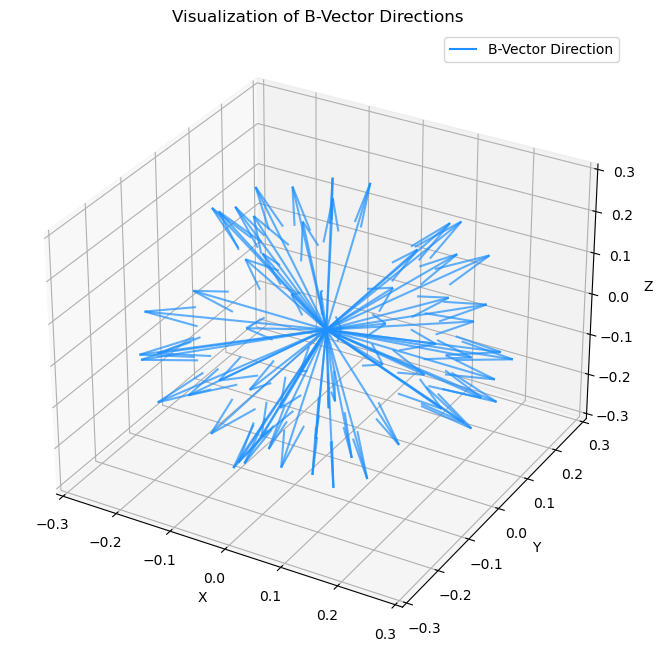

In [16]:
# Create a 3D plot for visualization of b-vector directions
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Convert b-vectors to a numpy array for manipulation
bvecs_array = np.array(bvecs)

# Initialize arrays for x, y, and z coordinates
x_coords = np.zeros(len(bvecs_array))
y_coords = np.zeros(len(bvecs_array))
z_coords = np.zeros(len(bvecs_array))

# Extract x, y, and z components of b-vectors
u = bvecs_array[:, 0]
v = bvecs_array[:, 1]
w = bvecs_array[:, 2]

# Set the arrow scale for visualization
arrow_scale = 0.3

# Create a quiver plot to visualize the b-vector directions
ax.quiver(x_coords, y_coords, z_coords, u, v, w, length=arrow_scale, normalize=True, color='dodgerblue', alpha=0.7)

# Set limits for the plot axes
ax.set_xlim(-arrow_scale, arrow_scale)
ax.set_ylim(-arrow_scale, arrow_scale)
ax.set_zlim(-arrow_scale, arrow_scale)

# Add labels and title to the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Visualization of B-Vector Directions')

# Add a legend for the arrows
ax.quiver(0.6, 0.6, 0.6, 1, 0, 0, length=0.2, color='dodgerblue', label='B-Vector Direction')
ax.legend()

# Display the 3D plot
plt.show()